In [29]:
import torch
import tensorly as tl
from tensorly.decomposition import parafac
from tensorly.cp_tensor import cp_to_tensor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random

In [30]:
tl.set_backend('pytorch')

In [31]:
tensor = torch.load('data/tcga_tensor.pt')
genes = np.load("data/genes.npy", allow_pickle=True)
patients = np.load("data/patients.npy", allow_pickle=True)
sample_types = np.load("data/sample_types.npy", allow_pickle=True)

In [32]:
# === Subsample First 1000 Genes for Benchmark ===
subset_genes = 1000
tensor = tensor[:subset_genes, :, :]
tensor = torch.log1p(tensor)

In [33]:
mask_bool = ~torch.isnan(tensor)
mask_float = mask_bool.float()

In [34]:
# === Simulate Random Missingness (20% randomly masked from observed entries) ===
missing_fraction = 0.2
mask_train_bool = mask_bool.clone()
mask_train_float = mask_float.clone()

In [35]:
# Get indices of observed entries
observed_indices = torch.nonzero(mask_train_bool, as_tuple=False)
num_mask = int(len(observed_indices) * missing_fraction)
masked_idx = observed_indices[torch.randperm(len(observed_indices))[:num_mask]]

In [36]:
# Apply masking
mask_train_bool[masked_idx[:, 0], masked_idx[:, 1], masked_idx[:, 2]] = False
mask_train_float[masked_idx[:, 0], masked_idx[:, 1], masked_idx[:, 2]] = 0.0

In [37]:
# Ground truth for evaluation
tensor_filled = torch.where(mask_bool, tensor, torch.tensor(0.0, dtype=tensor.dtype))

In [38]:
# === CP Completion Function (random init for memory efficiency) ===
def cp_completion(X_obs, mask, rank=10, n_iter=500):
    weights, factors = parafac(
        X_obs, rank=rank, n_iter_max=n_iter,
        mask=mask, init='random', svd='numpy_svd'
    )
    return cp_to_tensor((weights, factors))

In [39]:
# === Run Completion ===
rank = 10
X_obs = torch.where(mask_train_bool, tensor, torch.tensor(0.0, dtype=tensor.dtype))
X_pred = cp_completion(X_obs, mask_train_float, rank=rank)

In [40]:
# === Evaluate Performance ===
def evaluate(true_tensor, pred_tensor, eval_mask):
    true_vals = true_tensor[eval_mask]
    pred_vals = pred_tensor[eval_mask]
    rmse = torch.sqrt(torch.mean((true_vals - pred_vals) ** 2)).item()
    mae = torch.mean(torch.abs(true_vals - pred_vals)).item()
    return rmse, mae

In [41]:
rmse, mae = evaluate(tensor, X_pred, ~mask_train_bool & mask_bool)
print(f"\nEvaluation on masked entries:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}")


Evaluation on masked entries:
RMSE: 0.7137
MAE: 0.4232


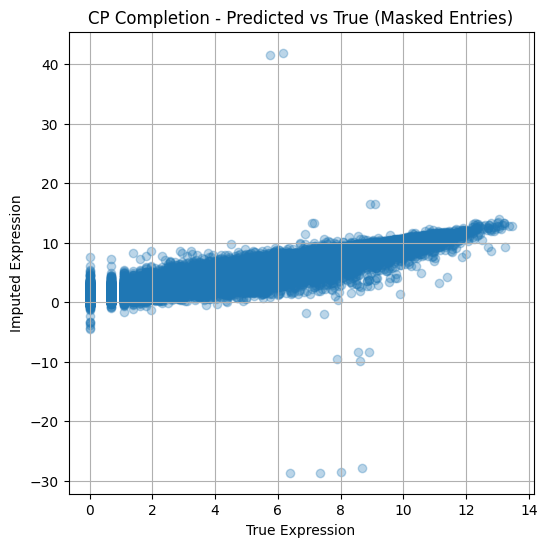

In [42]:
# === Visualizations ===
plt.figure(figsize=(6, 6))
plt.scatter(
    tensor[~mask_train_bool & mask_bool].cpu().numpy(),
    X_pred[~mask_train_bool & mask_bool].detach().cpu().numpy(),
    alpha=0.3
)
plt.xlabel("True Expression")
plt.ylabel("Imputed Expression")
plt.title("CP Completion - Predicted vs True (Masked Entries)")
plt.grid(True)
plt.show()